In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

**There are 25 variables:**

- ID: ID of each client
- LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit
- SEX: Gender (1=male, 2=female)
- EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
- MARRIAGE: Marital status (1=married, 2=single, 3=others)
- AGE: Age in years
- PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)
- PAY_2 ... PAY 6: scale same as above
- BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)
...
- BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)
- PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)
...
- PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)
- default.payment.next.month: Default payment (1=yes, 0=no), **positive class: default | negative class: pay**


<h2><b>Data Preparation</b></h2>

In [3]:
data = pd.read_csv('./UCI_Credit_Card.csv', index_col='ID')

In [4]:
data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
2,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
3,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
4,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
5,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [5]:
data.rename(columns=lambda x: x.lower(), inplace=True) # renaming the columns to lower case 

In [6]:
# Encoding the categorical data, otherwise scikitlearn would assume they are numerical features
# education: 1=graduate school, 2=university, 3=high school, 4=others
data['grad_school'] = (data['education'] == 1).astype('int')
data['university'] = (data['education'] == 2).astype('int')
data['high_school'] = (data['education'] == 3).astype('int')
# skipping the 4, because if all previous columns are 0, that means the person has other education
data.drop('education', axis=1, inplace=True) # dropping the education column after the encoding

# gender: (1=male, 2=female)
data['male'] = (data['sex'] == 1).astype('int')
data.drop('sex', axis=1, inplace=True)

# marriage: (1=married, 2=single, 3=others)
data['married'] = (data['marriage'] == 1).astype('int')
data.drop('marriage', axis=1, inplace=True)


In [7]:
# if the pay features are <= 0, there was no delay
pay_features = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
for pay in pay_features:
    data.loc[data[pay]<=0, pay] = 0 # changing all values <= 0 to 0

data.rename(columns={'default.payment.next.month': 'default'}, inplace=True) # renaming the label column

## **Building models with our features**

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import RobustScaler

In [9]:
target = 'default'
X = data.drop(target, axis=1)
scaler = RobustScaler()
X = scaler.fit_transform(X)
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=100, stratify=y)

In [10]:
def confMatrix(matrix, labels=['pay', 'default']):
    df = pd.DataFrame(data=matrix, index=labels, columns=labels)
    df.index.name = 'TRUE'
    df.columns.name = 'PREDICTION'
    df.loc['Total'] = df.sum()
    df['Total'] = df.sum(axis=1)
    return df

<h2>Preparing a DF for model analysis</h2>

In [11]:
# DF for evaluation metrics
metrics = pd.DataFrame(index=['accuracy', 'precision', 'recall'],
                       columns=['NULL', 'LogRegression', 'ClassTree', 'NaiveBayes'])



- **Accuracy**: the proportion of the total number of predictions that are correct
- **Precision**: the proportion of positive predictions that are correct
- **Recall**: the proportion of correctly predicted positive values

**In this application:**
- **Accuracy**: How often does the model correctly predict the defaulters
- **Precision**: When they model predicts **default**, how often is it correct?
- **Recall**: The proportion of the **correctly** predicted defaulters

**Which metric should I use?**
- **False Positive:** A person who will pay labeled as defaulter
- **False Negative:** A person who defaulted labeled as a payer

**False negatives are worse in this case, so we are going to look for a better recall**

<h2><b>The Null model that always predicts the most common category</b></h2>

In [12]:
y_pred_test = np.repeat(y_train.value_counts().idxmax(), y_test.size)
metrics.loc['accuracy', 'NULL'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision', 'NULL'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall', 'NULL'] = recall_score(y_pred=y_pred_test, y_true=y_test)

CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
confMatrix(CM)

C:\Users\alis\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


PREDICTION,pay,default,Total
TRUE,,,
pay,4673,0,4673
default,1327,0,1327
Total,6000,0,6000


## **Logistic Regression**

In [13]:
from sklearn.linear_model import LogisticRegression

# Creating an instance of the LogisticRegression estimator
log_reg = LogisticRegression(n_jobs=-1, random_state=100) # n_jobs=-1 to use all thread available

# Fitting the training data into our estimator
log_reg.fit(X_train, y_train)

# Evaluating the model
y_pred_test = log_reg.predict(X_test)
metrics.loc['accuracy', 'LogRegression'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision', 'LogRegression'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall', 'LogRegression'] = recall_score(y_pred=y_pred_test, y_true=y_test)

# Conf. matrix
CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
confMatrix(CM)

PREDICTION,pay,default,Total
TRUE,,,
pay,4491,182,4673
default,910,417,1327
Total,5401,599,6000


## **Classification Trees**

In [14]:
from sklearn.tree import DecisionTreeClassifier

# Creating an instance for the DecisionTreeClassifier
class_tree = DecisionTreeClassifier(min_samples_split=30, min_samples_leaf=10, random_state=100)

# Fitting the training data into our estimator
class_tree.fit(X_train, y_train)

# Evaluating the model
y_pred_test = class_tree.predict(X_test)
metrics.loc['accuracy', 'ClassTree'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision', 'ClassTree'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall', 'ClassTree'] = recall_score(y_pred=y_pred_test, y_true=y_test)

# Conf. matrix
CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
confMatrix(CM)

PREDICTION,pay,default,Total
TRUE,,,
pay,4248,425,4673
default,826,501,1327
Total,5074,926,6000


## **Naive Bayes**

In [15]:
from sklearn.naive_bayes import GaussianNB

# Creating an instance for the Gaussian Naive Bayes Classifier
naiveBayes = GaussianNB()

# Fitting the training data into our estimator
naiveBayes.fit(X_train, y_train)

# Evaluating the model
y_pred_test = naiveBayes.predict(X_test)
metrics.loc['accuracy', 'NaiveBayes'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision', 'NaiveBayes'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall', 'NaiveBayes'] = recall_score(y_pred=y_pred_test, y_true=y_test)

# Conf. matrix
CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
confMatrix(CM)

PREDICTION,pay,default,Total
TRUE,,,
pay,3898,775,4673
default,575,752,1327
Total,4473,1527,6000


In [16]:
# The DataFrame of our metrics in %
metrics*100

,NULL,LogRegression,ClassTree,NaiveBayes
accuracy,77.8833,81.8,79.15,77.5
precision,0,69.616,54.1037,49.2469
recall,0,31.4243,37.7543,56.6692


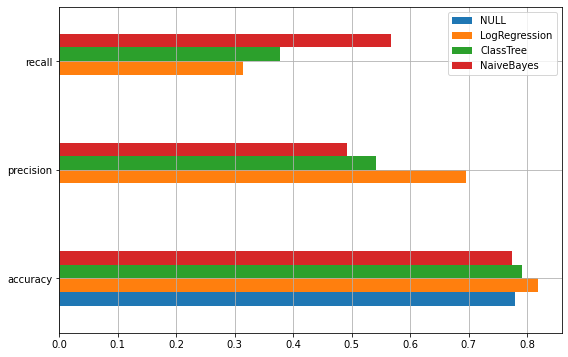

In [17]:
fig, ax = plt.subplots(figsize=(9,6))
metrics.plot(kind='barh', ax=ax)
ax.grid()

In [18]:
precision_nb, recall_nb, thresholds_nb = precision_recall_curve(y_true=y_test, 
                                                                probas_pred=naiveBayes.predict_proba(X_test)[:,1])
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_true=y_test,
                                                                probas_pred=log_reg.predict_proba(X_test)[:,1])

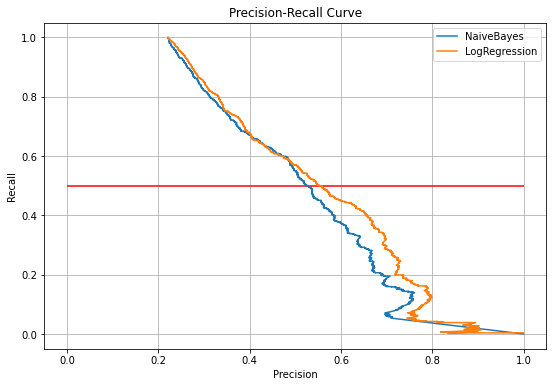

In [19]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(precision_nb, recall_nb, label='NaiveBayes')
ax.plot(precision_lr, recall_lr, label='LogRegression')
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.set_title('Precision-Recall Curve')
ax.hlines(y=0.5, xmin=0, xmax=1, color='red')
ax.legend()
ax.grid()

## Confusion matrix for modified Logistic Regression Classifier

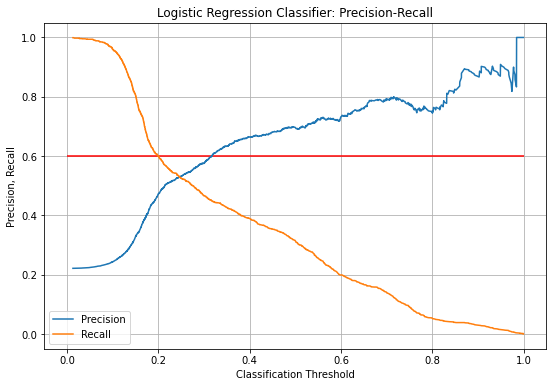

In [20]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(thresholds_lr, precision_lr[1:], label='Precision')
ax.plot(thresholds_lr, recall_lr[1:], label='Recall')
ax.set_xlabel('Classification Threshold')
ax.set_ylabel('Precision, Recall')
ax.set_title('Logistic Regression Classifier: Precision-Recall')
ax.hlines(y=0.6, xmin=0, xmax=1, color='red')
ax.legend()
ax.grid()

## **Classifier with threshold of 0.2**

In [21]:
y_pred_proba = log_reg.predict_proba(X_test)[:,1]
y_pred_test = (y_pred_test >= 0.2).astype('int')
# Confusion matrix
CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
print('Recall: ', 100*recall_score(y_pred=y_pred_test, y_true=y_test))
print('Precision: ', 100*precision_score(y_pred=y_pred_test, y_true=y_test))
confMatrix(CM)

Recall:  56.66917859834213
Precision:  49.24688932547478


PREDICTION,pay,default,Total
TRUE,,,
pay,3898,775,4673
default,575,752,1327
Total,4473,1527,6000


## **Making Individual Predictions**

In [22]:
def makePrediction(subject):
    data = subject.values.reshape(1, -1)
    data = scaler.transform(data)
    prob = log_reg.predict_proba(data)[0][1]
    if prob >= 0.2:
        return 'Will default'
    else:
        return 'Will pay'

In [23]:
pay = data[data['default']==0]

In [24]:
from collections import OrderedDict
new_customer = OrderedDict([('limit_bal', 4000), ('age', 50), ('bill_amt1', 500),
                            ('bill_amt2', 35509), ('bill_amt3', 689), ('bill_amt4', 0),
                            ('bill_amt5', 0), ('bill_amt6', 0), ('pay_amt1', 0), ('pay_amt2', 35509),
                            ('pay_amt3', 0), ('pay_amt4', 0), ('pay_amt5', 0), ('pay_amt6', 0),
                            ('male', 1), ('grad_school', 0), ('university', 1), ('high_school', 0),
                            ('married', 1), ('pay_0', -1), ('pay_2', -1), ('pay_3', -1),
                            ('pay_4', 0), ('pay_5', -1), ('pay_6', 0)])

new_customer = pd.Series(new_customer)
makePrediction(new_customer)

'Will default'